# II - Analyse, visualisation et feature engineering.

Cette deuxième partie se concentre sur l'analyse et la visualisation des données obtenues, ainsi que sur une construction de nouvelles variables pertinentes. Il est à noté qu'une dimension "feature engineering" était déjà présente dans la partie Récupération des données. Cependant, cette première construction de variable était nécessaire dans cette partie puisqu'il en allait davantage de "data engineering" plutôt que de data science à proprement parlé.

Nous rappelons que l'objectif principal de ce projet est de prédire la probabilité qu'une entreprise d'IDF dans les secteurs sélectionnés soit radié du RNE.

 On pourrait assimiler ici, par simplification, qu'une radiation fait suite à des difficultés de la part d'une entreprise. Ceci est simplificateur car en réalité, une entreprise peut être radié sur le champs, suivant immédiatement sa création, pour des raisons d'erreurs de remplissage de formalités, ou bien, suite à des décisions des entrepreneurs qui sans même avoir entreprit quelque chose, si ce n'est l'inscription au RCS et RNE, décident de fermer leur entité. D'autre part, une entreprise peut transférer un établissement vers un autre. Son établissement sera alors considéré comme radié par le RNE, alors qu'évidemment, l'aventure continue pour l'entrepreneur. 

De plus, créer une variable binaire "radié" sur l'ensemble de notre échantillon n'est pas très informatif. D'une part, la dimension temporelle serait ignorée. Par exemple, une entreprise peut être radiée du RNE 2 ans après sa création. Elle diffère alors des entreprises ayant été radié 1 mois après leur création. De plus, certaine entreprises crées récemment peuvent se voir attribuer la valeur 0 pour la variable binaire "radié". Or, nous n'observons pas si l'entreprise sera radié dans le futur. Nous tombons donc dans le cas d'une grande censure à droite de la variable "radié".

Il faudra donc construire des indicateurs de radiation des entreprises du RNE de manière à ce que, autant que possible, les biais dûs aux individualités propres à chaque entrepreneurs et entreprises, mais aussi dûs à la censure à droite nativement présente dans toutes données tabulaires faisant intervenir une notion de survie, soient limités.

Concernant le premier problème, il sera difficile de l'effacer complètement, et de pouvoir affirmer qu'en finalité, une variable "radié" relate d'une fermeture d'entreprise avec des difficultés. Il faudrait pour cela enrichir notre data frame d'observations du BODAC (Bulletin officiel des annonces civiles et commerciales) pour chaque entreprise, ou encore des observations des différents tribunaux de commerces : chose difficile dans le cadre d'un tel projet puisque le temps nous contraint, bien que possible... Ce point constituera notre principal axe d'amélioration. On tentera tout de même d'utiliser des variables récupérées lors de la partie récupération des données afin d'éviter certains biais.

In [1]:
#packages utilisés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

In [2]:
#Récupération du data frame de travail
from data.load_idf_10_24 import load_base
data = load_base()

Data Frame idf_10_24 récupéré depuis S3


On supprime les variables pour lesquelles nous n'avons pas jugé utiles pour ce projet, ainsi que celles résiduelles de la partie "récupération des données" :

In [3]:
drop = []

autre_ape = [f"autre_{i}_ape" for i in range(1,11)]
autre_statutFormalites = [f"autre_{i}_statutFormalites" for i in range(1,11)]
autre_role = [f"autre_{i}_role" for i in range(1,11)]
autre_adresse = [f"autre_{i}_adresse" for i in range(1,11)]
autre_datefin = [f"autre_{i}_datefin" for i in range(1,11)]
autre_dateeffetferm = [f"autre_{i}_dateeffetferm" for i in range(1,11)]
autre_datedebut = [f"autre_{i}_datedebut" for i in range(1,11)]
autre_dateeffettrans = [f"autre_{i}_dateeffettrans" for i in range(1,11)]
associe_naissance = [f"associe_{i}_naissance" for i in range(1,6)]


drop.extend([*autre_ape,*autre_statutFormalites,*autre_role,*autre_adresse,*autre_datefin,*autre_dateeffetferm,
                        *autre_datedebut,*autre_dateeffettrans,*associe_naissance])

drop.extend(["age0","age1","age2","age3","age4","age5"])


In [4]:
data = data.drop(columns=drop)

In [25]:
data

,siren,cessation,date_creation,etranger,micro,agricole,eirl,code_postal,codeInseeCommune,voie,...,total_rad4,ape_true4,total_exp5,total_rad5,ape_true5,nb_associe,mean_age,annee_tronc,pop_commune,nb_local_concurrents
0,300344389,0,2011-12-13,False,False,False,False,91370,91645,DE LA NOISETTE,...,0,0,0,0,0,1,50.198494,2011,15241.99811,3
1,300553369,0,2011-11-15,False,False,False,False,78000,78646,DES CHANTIERS,...,0,0,0,0,0,1,61.456537,2011,83102.16481,1
2,301848644,0,2012-12-05,False,False,False,False,95510,95651,GRANDE RUE,...,0,0,0,0,0,1,64.678987,2012,NaN,0
3,302342241,1,2014-09-02,False,False,False,False,95370,95424,SERGE LAUNAY,...,0,0,0,0,0,1,63.835729,2014,NaN,0
4,304514698,1,2013-05-07,False,False,False,False,75015,75115,JEANNE HACHETTE,...,0,0,0,0,0,1,41.097878,2013,NaN,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176458,982959231,0,2023-12-29,False,True,False,False,94450,94044,AVENUE DE LA SABLIERE,...,0,0,0,0,0,1,24.325804,2022,26745.98842,27
176459,982959132,0,2023-12-29,False,True,False,False,92120,92049,Delerue,...,0,0,0,0,0,1,58.324435,2022,45583.00444,25
176460,982969909,0,2023-12-30,False,True,False,False,78480,78642,Paul Doumer,...,0,0,0,0,0,1,36.328542,2022,15852.00100,9
176461,982975518,0,2023-12-31,False,False,False,False,78690,78220,du Pont de Mauregard,...,0,0,0,0,0,1,27.912389,2022,10228.33293,2


----------------

## II.1 - Construction de la variable cible, nettoyage du data frame, première selection des variables pertinentes et exploitables :


Dans le fichier excel de documentation des variables du RNE (présent ici : https://www.inpi.fr/sites/default/files/2025-06/Dictionnaire_de_donnees_INPI_2025_05_09.xlsx), il est stipulé que pour la variable `dateRadiation` :  "Si cette date est absente l'entreprise est active". On se basera donc sur cette variable pour construire notre variable cible.

### Stratégies pour limiter les biais liées aux imprévus, au contexte de chaque évènement de radiation du RNE :

- Nous enlevons les lignes pour lesquelles `indicateurDecesEntrepreneur` est disponible, ce qui veut dire qu'une personne physique est décédé.

- Les lignes pour lesquelles `dateClotureLiquidation`est disponible, qui concerne les personnes morales (par exemple sarl), puisqu'elle donne suite à une disparition de la personne morale ou bien ou une dissolution, sont à gardés par précaution. 
⚠️ En revanche, cette variable n'informe en aucun cas sur une potentiel liquidation judiciaire, qui elle est gage d'une entreprise en grave difficulté. Des variables sont disponibles au sein du RNE dans la partie "Observations", relatant des évènements du BODAC (Bulletin officiel des annonces civiles et commerciales). Il serait donc possible en pratique d'obtenir ces informations. Il serait possible de traiter ces textes avec des méthodes de NLP pour identifier les liquidations judiciaires des liquidations sur décision de l'entreprise, des transferts de sièges sociaux vers d'autres entreprises mères etc... Cependant, le nombre d'observations est parfois élevé pour une seule entreprise, et la mise en forme de data frame n'est pas très adapté à cela. C'est pourquoi nous précisons que nous faisons l'impasse sur cette information, d'une part par manque de temps, et d'autre part, en cause, la récupération des données depuis les fichiers json est très lourde. C'est un point net d'amélioration du projet. C'est la raison pour laquelle nous appelons notre variable cible "radié" et non "faillite"" ou encore "radié car difficulté".

- Nous disposons tout de même de la variable `principalDateTransPrincipal` indiquant s'il y a eu un transfert de l'établissement principal. Les lignes pour lesquelles cette variable est disponible ne seront donc pas gardées.

- Nous supprimons les lignes pour lesquelles il y a un intervalle de moins  de 2 mois entre la date de création et la date de radiation. Cela nous protégera un peu mieux des décisions de fermeture immédiate, ou des radiations d'office dues à des erreurs de formalités.

- Nous supprimons les lignes pour lesquelles `dateRadiation` < `date_creation`, qui sont peu nombreuses et probablement du à des erreurs natifs du RNE.

### Stratégies pour contrecarrer les censures à droite et prendre en compte les dimensions temporelles de "survie" : 

- Nous partons sur la modélisation suivante pour la radiation des entreprises du RNE : nous considérons la non-survie des entreprises au sens d'une radiation au RNE pour plusieurs horizons temporels : 1 an, 2 ans, 3 ans, 4 ans, et 5 ans. On créer alors 5 variables binaires de la manière suivantes : Si $T$ est la variable aléatoire du temps écoulé (en jour) entre la création d'entreprise et de la radiation au RNE de celle-ci, conditionnellement au fait d'avoir été radié du RNE on définie alors 

$radié_1 = \begin{cases} 0 \text{ si } T > 365 \\ 1 \text{ si } 60 < T \leq 365 \end{cases}$     

$radié_2 = \begin{cases} 0 \text{ si } T > 365*2  \\ 1 \text{ si } 365 < T \leq 365*2 \end{cases}$ 

$radié_3 = \begin{cases} 0 \text{ si } T > 365*3  \\ 1 \text{ si } 365*2 < T \leq 365*3 \end{cases}$    

$radié_4 = \begin{cases} 0 \text{ si } T > 365*4  \\ 1 \text{ si } 365*3 < T \leq 365*4 \end{cases}$ 

$radié_5 = \begin{cases} 0 \text{ si } T > 365*5  \\ 1 \text{ si } 365*4 < T \leq 365*5 \end{cases}$

Ce choix de modélisation nous permettra de se restreindre à un horizon donné, ce qui est beacoup plus informatif qu'une simple variable binaire sur tout l'échantillon. Par exemple, une entreprise pour laquelle $radié_2 = 1$ nous dira que l'entreprise à été radiéé au cours de la deuxième année de on existence. 

- Pour éviter la censure à droite des entreprises, nous devons nous restreindre aux dates de créations étant inférieur à 2021, afin d'obtenir au minimum une vue sur 5 ans pour toutes les entreprises. Cela est tout de même contraignant, puisque cela ne permettra pas de prendre en compte des dynamiques changeantes depuis 2021 jusqu'à aujourd'hui, et donc pourrait fausser les prédictions. De plus, certaines activités n'existaient pas avant 2021. Tous ces problèmes peuvent être limités en considérant un jeu de donnée "adapté" pour chaque variable $radié_i$, $i \in \{1,2,3,4,5\}$.

--------------

On rappelle d'abord les variables obtenues lors de la partie "récupération des données" :

In [114]:
all_columns = data.columns.tolist()
print(all_columns)

['siren', 'cessation', 'date_creation', 'etranger', 'micro', 'agricole', 'eirl', 'code_postal', 'codeInseeCommune', 'voie', 'typeVoie', 'numVoie', 'dateRadiation', 'dateEffet', 'denomination', 'formeJuridique', 'codeAPE', 'dateImmat', 'dateDebutAct', 'personneMorale', 'nicSiege', 'objet', 'capitalVariable', 'montantCapital', 'formeExerciceActivitePrincipale', 'nom', 'prenoms', 'genre', 'rolePourEntreprisePrincipal', 'statutPourFormalitePrincipal', 'principalAPEPrincipal', 'principalDateTransPrincipal', 'indicateurDecesEntrepreneur', 'dateCessationTotaleActivite', 'dateClotureLiquidation', 'dateDissolutionDisparition', 'indicateurCessationTemporaire', 'indicateurPoursuiteActivite', 'indicateurMaintienImmatriculationRegistre', 'indicateurDissolution', 'indicateurDisparitionPM', 'motifDisparition', 'dateMiseEnSommeil', 'typeDissolution', 'nb_autres', 'diffusionINSEE', 'diffusionCommerciale', 'age_physique', 'autre_1_ape', 'autre_2_ape', 'autre_3_ape', 'autre_4_ape', 'autre_5_ape', 'autre_

On met en application le premier volet de notre stratégie pour la construction des variables cibles.

In [34]:
#Suppression des lignes pour lesquelles indicateurDecesEntrepreneur est True
data = data.loc[data["indicateurDecesEntrepreneur"]!="True"]

In [35]:
#Suppression des lignes pour lesquelles principalDateTransPrincipal est disponible 
data = data.loc[data["principalDateTransPrincipal"].isin(("non-disp","pincipal_false_transfert"))]

In [36]:
#Création de la variable T
data["date_creation"] = pd.to_datetime(data["date_creation"])
data["dateRadiation"] = pd.to_datetime(data["dateRadiation"],errors = "coerce")

data["T"] = data["dateRadiation"] - data["date_creation"]

In [37]:
#Suppresion des lignes pour lesquelles la différence entre la date de création et la date de radiation (T) est inférieur à 60 jours
data = data.loc[~(data["T"].dt.days < 60)]

In [38]:
#Suppression des lignes pour lesquelles date_creation > dateRadiation
data = data.loc[~(data["T"].dt.days < 0)]

On construit maintenant nos variables cibles :

In [48]:
data["T"] = data["T"].dt.days

In [60]:
data.loc[~(data["T"] > 365)]["T"].shape[0] - 3880

121440

## II.2 - Etude des corrélations potentielles entre variable explicatives et variables cibles ; visualisation : 

+ extrem value + normalisation (mise à l'echelle) + one hot

In [4]:
#Récupération du data frame de travail
from data.load_idf_10_24 import load_base
data = load_base()

Data Frame idf_10_24 récupéré depuis S3


In [5]:
#Construction de la variable cible "radié"
data["dateRadiation"] = pd.to_datetime(data["dateRadiation"],errors="coerce")
data["radié"] = data["dateRadiation"].notna().astype(int)

In [6]:
#Pourcentage d'entreprise radié sur notre échantillon
print(round(data["radié"].sum()/data.shape[0]*100,4), "%")

29.8777 %


## Analyse sur la période total 2010 - 2024

### Le département à t-il un impact sur le nombre d'entreprises radiées en son sein ?

Visualisons d'abord le % d'entreprise radiée par département évalué sur l'ensemble de l'échantillon (nombre d'entreprise crées entre 2010 et 2024), puis celui relatif au nombre d'entreprise crées au sein d'un département pour corriger des effets "tailles".

In [7]:
#Récupération des départements 
data["cp"] = data["code_postal"].apply(lambda x : x[0:2])

In [8]:
data["cp"]

0         91
1         78
2         95
3         95
4         75
          ..
176458    94
176459    92
176460    78
176461    78
176462    78
Name: cp, Length: 176463, dtype: object

In [9]:
#Nombre d'entreprise radié par département; nombre d'entreprise par département disponibles
rad_dep = data.loc[data["radié"] == 1].groupby("cp").size().reset_index(name="nb_radié")
total_dep = data.groupby("cp").size().reset_index(name="nb_firme/dep")
df_plot_dep = total_dep.merge(rad_dep, on = "cp", how="left")
df_plot_dep["nb_firme/total"] = data.shape[0]

In [10]:
#Pourcentage d'entreprise radiées par departement en % du total
df_plot_dep["pct_total"] = df_plot_dep["nb_radié"]/df_plot_dep["nb_firme/total"]

#Pourcentage d'entreprise radiées par dep en % par département
df_plot_dep["pct_relatif"] = df_plot_dep["nb_radié"]/df_plot_dep["nb_firme/dep"]

On remarque qu'il y a globalement un effet taille et qu'il est plus pertinent de raisonner en % non du total mais du nombre de firme dans chaque département crées entre 2010 et 2024.

La Seine-Saint-Denis arrive en pôle position du nombre d'entreprise radiée, avec environ 37% d'entreprise radiées sur la période. Il y a équivalence entre le 77, 91; 92 et 94, pour environ 33% d'entreprises radiées.

Les Yvelines et le Val-d'Oise sont moins touchés : 28% et 30% environ des entreprises crées dans ces départements respectifs. Paris remporte la compétition des entreprises les moins radiées sur la période total, avec seulement 22% d'entreprises radiées sur l'ensemble de la période, sur le nombre total d'entreprises Parisiennes crées sur la période.

Ainsi sur la période global, il semble se dessiner des hétérogénéité entre département sur le nombre d'entreprises radiées. Paris semble plus robuste que les autres. Il faudra donc évaluer la pertinence de la variable catégorielle "dep" dans une future modélisation.

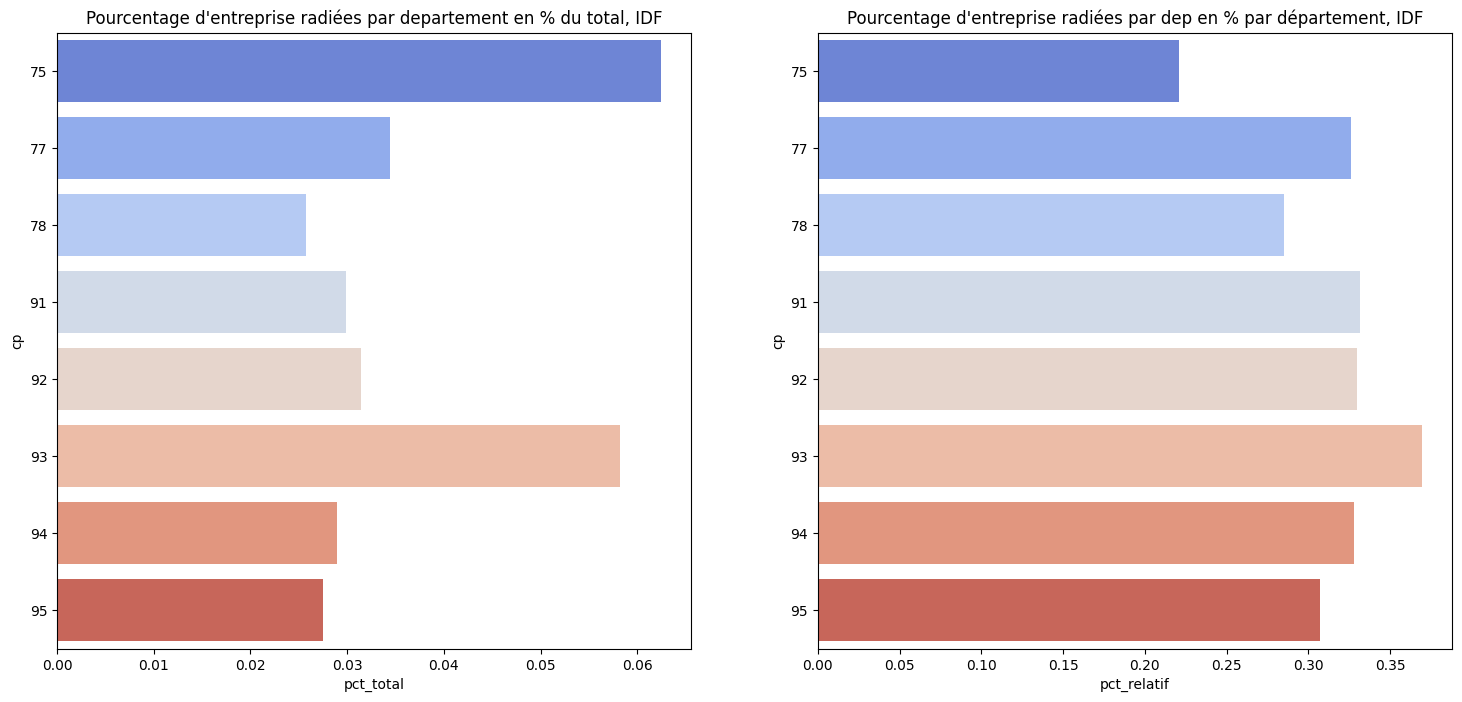

In [ ]:
#barplot 
fig, ax = plt.subplots(1,2,figsize=(18,8))
sns.barplot(x = "pct_total", y= "cp", hue = "cp", data=df_plot_dep, palette="coolwarm", ax = ax[0])
ax[0].set_title("Pourcentage d'entreprise radiées par departement en % du total, IDF")

sns.barplot(x = "pct_relatif", y= "cp", hue="cp",data=df_plot_dep,palette="coolwarm", ax = ax[1])
ax[1].set_title("Pourcentage d'entreprise radiées par dep en % par département, IDF")
plt.show()

### La taille de la commune d'implentation peut-elle jouer dans sur le nombre d'entreprise radié ? La concurrence locale est-elle un facteur d'échec ?

L'effet n'est pas forcément très claire : d'un côté on pourrait penser que s'implanter dans une grande ville pourrait augmenter la probabilité de "réussir" en trouvant une demande conséquente. Mais de l'autre côté, le nombre de concurrent pourrait être accru, et il serait dans ce cas probablement délétère de s'installer dans une grande ville en tant que commerçant, restaurateur ou hôtelier. 

Pour cela, on considère trois types de villes : 

                                            - les villages, comprenant de 0 à 5000 habitants (valeur "village")
                                            - les villes dites "petites", comprenant de 5000 à 25 000 habitants (valeur "little")
                                            - les villes dites "moyennes", comprenant de 25 000 à 50 000 habitants (valeur "middle")
                                            - les villes dites "grandes", comprenant plus de 50 000 habitants (valeur "big")

On utilise pour cela la variable `pop_commune` et on créer une nouvelle variable nommé `taille_ville` :

In [ ]:
#Création de taille_ville
data["taille_ville"] = data["pop_commune"].apply(
    lambda x: "village" if x < 5000
    else "little" if x < 25000
    else "middle" if x < 50000
    else "big"
)

Le graphique suivant est assez tautologique mais montre bien que plus il y a un grand nombre d'habitant, plus il y a d'entreprise crées...

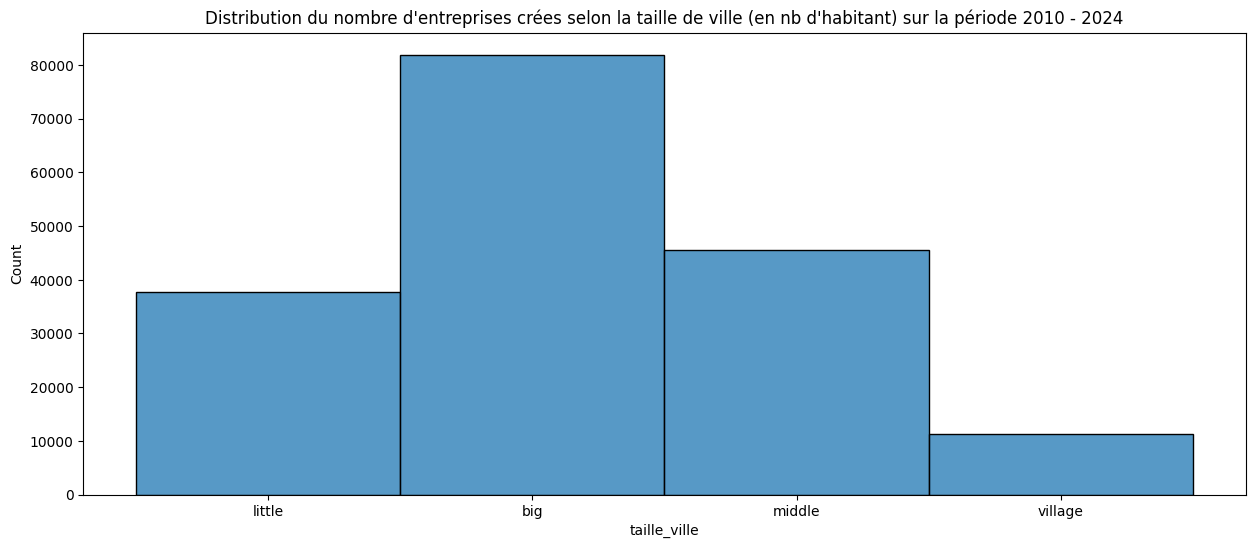

In [28]:
#distribution du nombre d'entreprises crées selon la taille de ville (en nb d'habitant) sur la période 2010 - 2024
plt.figure(figsize=(15,6))
sns.histplot(x="taille_ville",data = data)
plt.title("Distribution du nombre d'entreprises crées selon la taille de ville (en nb d'habitant) sur la période 2010 - 2024")
plt.show()

In [41]:
#préparation pour graphique % de radiation par rapport au nombres d'entrerpises crées dans les catégories de taille_ville
nb_rad = data.loc[data["radié"] == 1].groupby("taille_ville").size().reset_index(name="nb_radié")
nb_crees = data.groupby("taille_ville").size().reset_index(name="nb_crées")
df_plot_hab = nb_rad.merge(nb_crees,on="taille_ville",how="left")

df_plot_hab["pct_radié"] = df_plot_hab["nb_radié"]/df_plot_hab["nb_crées"]

Etonnemment, rapporter au nombre d'entreprise crées au sein de chaque typologie de ville, il semble y avoir une grande homogénéité.
La variable "taille_ville" sera donc très peu informative pour une modélisation de la radiation d'entreprise.

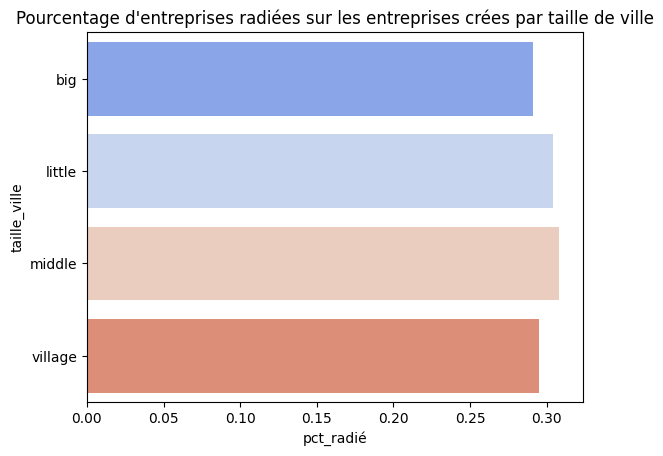

In [51]:
fig, ax = plt.subplots()
sns.barplot(x="pct_radié", hue = "taille_ville", y="taille_ville",data = df_plot_hab,palette="coolwarm",ax = ax )
ax.set_title("Pourcentage d'entreprises radiées sur les entreprises crées par taille de ville")
plt.show()

Pour essayer de mieux saisir les choses, évaluons le ratio nombre de concurrents locaux / nombre d'habitant, et regardons si celui-ci est corrélé à la radiation d'entreprise. En principe, on s'attend à ce que plus le nombre de concurrent est élevé par rapport au nombre d'habitant, plus les marchés sont saturés; en raisonnant naivement ici sur tout type de secteurs confondus.

In [52]:
data["concu/hab"] = data["nb_local_concurrents"]/data["pop_commune"] 

On effectue un test de corrélation pour évaluer la significativité de la corrélation entre "radié" et "concu/hab".

Pour cela, on peut considérer la régression linaire suivant : 
    $\hat{concu/hab} = \hat{\alpha} + \hat{\beta} * radié$.

Sous des hypothèses de moments, d'indépendance et d'inversibilité (ici toutes vérifiés trivialement puisque radié est binaire, et qu'il est a priori certain que les couples $(concu/hab_i, radié_i)$ soient indépendants), peut effectuer sereinement le test de significativité suivant :

 $H_0$ : $\beta = 0$ VS $H_1$ : $\beta \neq 0$




Ainsi il semble y avoir une corrélation significative au seuil asymptotique de 5% entre concu/hab et radié. $\hat{\beta}$ vaut -0.000464 et le signe de la corrélation est négatif. Cependant, l'effet semble fable en volume, puisque toutes chose égale par ailleurs, le fait d'être une entreprise radié est corrélé à une diminution de 0.000464 du ratio concu/hab. Il faudra donc évalué la pertinence de concu/hab à travers une selection de variable dans la partie modélisation.

In [ ]:

X = data.loc[~data["concu/hab"].isna()]["radié"]
X = sm.add_constant(X)
y = data.loc[~data["concu/hab"].isna()]["concu/hab"]

#On regresse et on récupère les écarts types robustes
model = sm.OLS(y, X).fit(cov_type="HC1")
print(model.summary())
print(model.params)

                            OLS Regression Results                            
Dep. Variable:              concu/hab   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     421.6
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.43e-93
Time:                        16:12:19   Log-Likelihood:             6.8858e+05
No. Observations:              174357   AIC:                        -1.377e+06
Df Residuals:                  174355   BIC:                        -1.377e+06
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016    1.4e-05    116.457      0.0

In [129]:
#Récupération du nb d'entreprise radié par année depuis 2010
annee = [i for i in range(2010,2026)]
df_plot_dep_year = list()
for y in annee : 
    y_name = f"nb_rad_{y}"
    df_it = data.loc[(data["dateRadiation"].dt.year == y) & (~data["dateRadiation"].isna())].groupby("cp").size().reset_index(name = y_name)
    df_plot_dep_year.append(df_it)


In [75]:
#Groupby par année
year = data.loc[data["radié"] == 1].groupby(["cp","year"]).size().reset_index(name="nb_radié_year")

In [79]:
year.loc[year["cp"]=="93"]

,cp,year,nb_radié_year
70,93,2010,394
71,93,2011,360
72,93,2012,453
73,93,2013,460
74,93,2014,582
75,93,2015,705
76,93,2016,1010
77,93,2017,1178
78,93,2018,1195
79,93,2019,1204


## II.3 - Construction de nouvelles variables; visualisation :